## Jupyter Notebook for the Machine Learning Project at neue fische

Data-source: https://www.kaggle.com/datasets/ulrikthygepedersen/kickstarter-projects/data.  
This 4 days project was in colaboration with Naomi Pletner & Dr. Susan Gritzka, as part of the neue fische Data Science, Machine Learning & AI Bootcamp.  

The aim of this project was to archieve a ML-model predicting the success likelyhood of Kickstarter campaigns.
We focused on creating a model, that was independent of Pledge and Backers but trained to identify the success rate by the Category, Subcategory, their Goal and the Country from where the campaign started. 
Using feature engineereing, we involved the launch month, the launch day (in the week), Project Duration, (Campaign-)Name length and performed a sentiment analysis of the (Campaign-)Name.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import sklearn as sk
import missingno as msno
from scipy.stats import zscore, boxcox
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", color_codes=True)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set global variables for plots
plt.style.use('fivethirtyeight')
sns.set_color_codes('bright')
plt.rcParams["figure.figsize"] = (4, 4)

RSEED = 42

## Part 1: EDA

In [142]:
# import dataset
df = pd.read_csv('/home/nvy/Schreibtisch/Bildung/Coding/neueFische/Exercises/Projects/MachineLearning_Project/Data/kickstarter_projects.csv')
df.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.5+ MB


In [144]:
df.describe()

,ID,Goal,Pledged,Backers
count,3.748530e+05,3.748530e+05,3.748530e+05,374853.000000
mean,1.074656e+09,4.586378e+04,9.121073e+03,106.690359
std,6.191377e+08,1.158778e+06,9.132054e+04,911.718520
min,5.971000e+03,0.000000e+00,0.000000e+00,0.000000
25%,5.380728e+08,2.000000e+03,3.100000e+01,2.000000
50%,1.075300e+09,5.500000e+03,6.250000e+02,12.000000
75%,1.610149e+09,1.600000e+04,4.051000e+03,57.000000
max,2.147476e+09,1.663614e+08,2.033899e+07,219382.000000


In [145]:
df.columns

Index(['ID', 'Name', 'Category', 'Subcategory', 'Country', 'Launched',
       'Deadline', 'Goal', 'Pledged', 'Backers', 'State'],
      dtype='object')

In [146]:
# check for duplicates:
df.ID.duplicated().sum()

0

In [147]:
# check for the unique status options
df.State.unique()

array(['Failed', 'Successful', 'Canceled', 'Suspended', 'Live'],
      dtype=object)

In [148]:
# explore the dataset: how many campaigns are not finished yet?
df.query('State == "Live"').count()

ID             2798
Name           2798
Category       2798
Subcategory    2798
Country        2798
Launched       2798
Deadline       2798
Goal           2798
Pledged        2798
Backers        2798
State          2798
dtype: int64

In [149]:
# explore the dataset: how many campaigns were suspended?
df.query('State == "Suspended"').count()

ID             1842
Name           1842
Category       1842
Subcategory    1842
Country        1842
Launched       1842
Deadline       1842
Goal           1842
Pledged        1842
Backers        1842
State          1842
dtype: int64

In [150]:
# explore the dataset: how many campaigns are successfully or unsuccessfully finished
df[(df['State']=='Successful') | (df['State']=='Failed')].count()

ID             331462
Name           331462
Category       331462
Subcategory    331462
Country        331462
Launched       331462
Deadline       331462
Goal           331462
Pledged        331462
Backers        331462
State          331462
dtype: int64

In [151]:
# explore the dataset: how many campaigns finished successfully?
df[(df['State']=='Successful')][['Goal', 'Pledged']].count()

Goal       133851
Pledged    133851
dtype: int64

In [152]:
# explore the dataset: how many campaigns are successfully finished and pledged less money than they set as a goal?
df[(df['State']=='Successful')&(df['Pledged']<df['Goal'])]


,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
258920,1769772834,Borders of the Imagination - An Epic Sci-Fi/Fa...,Film & Video,Shorts,United States,2015-11-12 19:06:18,2015-12-27,36000,30716,275,Successful
272350,780863434,TUW Ruhla Watches - Comeback of a Legend,Design,Product Design,Germany,2016-02-08 19:14:02,2016-03-19,27885,27765,90,Successful


In [153]:
# explore the dataset: how many campaigns failed although, they pledged more/as much money as they set as a goal?
df[(df['State']=='Failed')&(df['Pledged']>= (df['Goal']))]

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
2295,2103203254,The new face of Canadian Science Fiction,Publishing,Fiction,United States,2010-03-18 04:35:31,2010-05-16,10000,10797,66,Failed
5754,1695255515,"POPE! an epic musical, opening at NY Fringe Fe...",Theater,Theater,United States,2010-07-21 05:48:11,2010-08-20,3600,3600,30,Failed
25983,790638930,From Neurons to Nirvana: The Great Medicines,Film & Video,Documentary,United States,2011-07-25 20:35:41,2011-09-23,40000,40000,113,Failed
33823,1297794474,Music Empowers - A Day with the Accende Ensemble,Music,Classical Music,United States,2011-11-07 15:20:24,2012-01-04,3000,3088,20,Failed
40294,9572984,Nana,Film & Video,Shorts,United States,2012-01-25 07:23:19,2012-03-16,0,0,0,Failed
62467,416370896,Tye Gazoo,Music,Country & Folk,United States,2012-07-20 22:15:08,2012-08-11,3000,3000,24,Failed
86441,1085047405,"""Balance""",Music,Jazz,United States,2013-03-05 10:55:56,2013-04-04,23000,23020,141,Failed
108392,59246799,Key Wrench - Unlock Your Life!,Design,Product Design,United States,2013-08-24 05:42:10,2013-10-04,6000,6183,208,Failed
151769,1257771766,Egg Salad,Food,Food,United States,2014-07-08 23:23:48,2014-08-07,10,10,1,Failed
259754,818363688,The 5th Annual 90 Square Arts Festival,Theater,Festivals,United States,2015-11-17 07:11:53,2016-01-06,12000,12000,77,Failed


In [154]:
# explore the dataset: how many failed in total?
df[df['State']=="Failed"]['ID'].count()

197611

In [155]:
# explore the dataset: how many succeded in total?
df[df['State']=="Successful"]['ID'].count()

133851

In [156]:
# explore the dataset: how many had 0$ as goal?
df[df['Goal'] == 0]

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
1085,620302213,LOVELAND Round 6: A Force More Powerful,Art,Conceptual Art,United States,2009-11-25 07:54:49,2009-12-04,0,100,6,Successful
33831,688564643,"Word-of-mouth publishing: get ""Corruptions"" ou...",Publishing,Fiction,United States,2011-11-07 16:46:52,2011-12-13,0,0,0,Canceled
40294,9572984,Nana,Film & Video,Shorts,United States,2012-01-25 07:23:19,2012-03-16,0,0,0,Failed
316197,1379346088,Bug's Big Adventure: Mexico Edition,Art,Art,Mexico,2016-11-11 16:30:00,2016-11-12,0,16,7,Successful


In [157]:
# explore the dataset: how many had no backers and were successful?
df[(df['Backers']==0)&(df['State']=="Successful")]

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State


In [158]:
# explore the dataset: how many had no backers but still a Pledged?
df[(df['Pledged']!=0)&(df['Backers']==0)]

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
5115,950767056,Sins Of A Son,Film & Video,Documentary,United States,2010-07-02 23:41:15,2010-09-04,3500,1,0,Failed
185102,2044861703,iStandUp!,Design,Product Design,United States,2014-11-19 19:20:02,2014-12-31,50000,218,0,Failed
282368,1354010125,The Falcon Fly By,Film & Video,Film & Video,United States,2016-04-05 15:08:31,2016-06-04,5000,1,0,Failed


In [159]:
# explore the dataset: how many doubled/repeated projects do we have? -> 'Name' ist the name of the campaign/project!
df[df['Name'].duplicated()==True]

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
6252,1705926108,NIJINSKY IN ASYLUM,Theater,Theater,United States,2010-08-04 07:04:52,2010-09-01,2000,2021,46,Successful
11959,608777297,MATTE Magazine,Photography,Photography,United States,2011-01-04 01:47:23,2011-03-02,300,301,7,Successful
13004,903412916,The Busking Project,Film & Video,Documentary,United States,2011-01-24 21:56:28,2011-03-09,3000,3278,44,Successful
14428,1511162166,The Fears Project,Film & Video,Shorts,United States,2011-02-16 01:34:20,2011-03-18,500,550,8,Successful
15562,1402922171,Spin,Film & Video,Film & Video,United States,2011-03-04 22:45:04,2011-04-04,5000,50,2,Failed
...,...,...,...,...,...,...,...,...,...,...,...
374625,192967537,Short Film,Film & Video,Film & Video,United States,2017-12-29 19:07:22,2018-01-28,5000,0,0,Live
374669,2080425836,PerfectCombination: Help Us Turn The Dating Wo...,Technology,Web,United Kingdom,2017-12-30 17:41:08,2018-01-29,13640,0,0,Live
374672,1442880158,Solstice,Publishing,Fiction,United Kingdom,2017-12-30 19:33:00,2018-01-29,4092,79,2,Live
374755,1812821305,100 Little Loaves,Art,Sculpture,United States,2018-01-01 07:24:18,2018-01-31,1000,745,6,Live


In [160]:
# converting the launch date from object to datetime:
df['Launched'] = pd.to_datetime(df['Launched'])

# defining a new column with Year-Month-Day without the daytime:
df['Launch_date'] = df['Launched'].dt.strftime('%Y-%m-%d')
df['Launch_date'] = pd.to_datetime(df['Launch_date'])

In [161]:
# converting the deadline date from object to datetime
df['Deadline'] = pd.to_datetime(df['Deadline'])
df['Deadline'], df['Deadline'].dtypes

(0        2009-05-31
 1        2009-07-20
 2        2009-05-03
 3        2009-07-14
 4        2009-05-26
             ...    
 374848   2018-01-16
 374849   2018-02-09
 374850   2018-01-16
 374851   2018-02-01
 374852   2018-01-26
 Name: Deadline, Length: 374853, dtype: datetime64[ns],
 dtype('<M8[ns]'))

In [162]:
# create anew column to calcuklate the total duration of the project
df['Project_Duration'] = df['Deadline'] - df['Launched']
df['Project_Duration'] = df['Project_Duration'].dt.days
df.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State,Launch_date,Project_Duration
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed,2009-04-21,39
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed,2009-04-23,87
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful,2009-04-24,8
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful,2009-04-25,79
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed,2009-04-27,28


In [163]:
# creating a column calculating the length of the project Name:
df['Name_length'] = df['Name'].str.len()
df[['Name','Name_length']]

,Name,Name_length
0,Grace Jones Does Not Give A F$#% T-Shirt (limi...,59
1,CRYSTAL ANTLERS UNTITLED MOVIE,30
2,drawing for dollars,19
3,Offline Wikipedia iPhone app,28
4,Pantshirts,10
...,...,...
374848,Americas Got Talent - Serious MAK,33
374849,EVO Planner: The World's First Personalized Fl...,55
374850,"Help save La Gattara, Arizona's first Cat Cafe!",47
374851,Digital Dagger Coin,19


In [164]:
df.groupby("Country")["Goal"].mean()

Country
Australia          58108.245695
Austria            44652.410385
Belgium            37322.197731
Canada             44408.446666
Denmark            35581.366577
France             81047.384825
Germany            75208.411172
Hong Kong          23865.632686
Ireland            47405.963009
Italy              78807.780751
Japan              16596.850000
Luxembourg         33783.145161
Mexico             14869.956050
Netherlands       109507.033473
New Zealand        25572.476849
Norway             67440.316384
Singapore          15474.713514
Spain              52578.876538
Sweden             40994.186682
Switzerland       271636.161842
United Kingdom     42775.306673
United States      44035.392119
Name: Goal, dtype: float64

In [165]:
df.Category.unique(), df.Subcategory.unique()
# group by categories

(array(['Fashion', 'Film & Video', 'Art', 'Technology', 'Journalism',
        'Publishing', 'Theater', 'Music', 'Photography', 'Games', 'Design',
        'Food', 'Crafts', 'Comics', 'Dance'], dtype=object),
 array(['Fashion', 'Shorts', 'Illustration', 'Software', 'Journalism',
        'Fiction', 'Theater', 'Rock', 'Photography', 'Puzzles',
        'Graphic Design', 'Film & Video', 'Publishing', 'Documentary',
        'Sculpture', 'Electronic Music', 'Nonfiction', 'Food', 'Painting',
        'Indie Rock', 'Video Games', 'Public Art', 'Product Design', 'Art',
        "Children's Books", 'Crafts', 'Jazz', 'Music', 'Comics',
        'Narrative Film', 'Tabletop Games', 'Digital Art', 'Animation',
        'Conceptual Art', 'Pop', 'Hip-Hop', 'Country & Folk',
        'Periodicals', 'Webseries', 'Performance Art', 'Technology',
        'Art Books', 'World Music', 'Knitting', 'Classical Music',
        'Poetry', 'Graphic Novels', 'Radio & Podcasts', 'Design',
        'Hardware', 'Webcomics', 'D

In [166]:
# splitting the df to cut out the unfinished (live) campaigns/projects
df_live = df.query('State == "Live"')

# saving the live-df as file
df_live.to_csv('/home/nvy/Schreibtisch/Bildung/Coding/neueFische/Exercises/Projects/MachineLearning_Project/Data/df_live.csv')


In [167]:
# creating a new df excluding the "live","suspended" and "canceled" states.
df2 = df[(df['State']=="Successful")|(df['State']=="Failed")]
df2.count() 

ID                  331462
Name                331462
Category            331462
Subcategory         331462
Country             331462
Launched            331462
Deadline            331462
Goal                331462
Pledged             331462
Backers             331462
State               331462
Launch_date         331462
Project_Duration    331462
Name_length         331462
dtype: int64

In [168]:
#df2[df2['Launch_date']>=2013-04-21]


In [169]:
# dropping the lines with and goal of 0$:
df2 = df2[~(df2['Goal'] == 0)]

# dropping the lines where projects got money although no one pledged:
df2 = df2[~((df2['Pledged']!=0)&(df2['Backers']==0))]

# dropping lines where the project succeded although they didn't pledged enought money:
df2 = df2[~((df2['State']=='Successful')&(df2['Pledged']<df2['Goal']))]

# dropping lines where the project failed although they pledged enought money:
df2 = df2[~((df2['State']=='Failed')&(df2['Pledged']>=df2['Goal']))]

# excluding data from before 2013:
df2 = df2[~(df2['Launch_date']<"2013-01-01")]

In [170]:
df2.describe()

,ID,Launched,Deadline,Goal,Pledged,Backers,Launch_date,Project_Duration,Name_length
count,2.581710e+05,258171,258171,2.581710e+05,2.581710e+05,258171.000000,258171,258171.000000,258171.000000
mean,1.073559e+09,2015-06-18 22:05:28.023840768,2015-07-21 03:16:36.832332544,4.921937e+04,1.101209e+04,125.900523,2015-06-18 08:16:52.352278272,31.791518,33.859678
min,1.852000e+04,2013-01-01 00:06:38,2013-01-05 00:00:00,1.000000e+00,0.000000e+00,0.000000,2013-01-01 00:00:00,0.000000,1.000000
25%,5.357251e+08,2014-07-01 21:44:49,2014-08-01 00:00:00,2.000000e+03,3.100000e+01,2.000000,2014-07-01 00:00:00,29.000000,20.000000
50%,1.074493e+09,2015-05-18 23:33:33,2015-06-20 00:00:00,5.830000e+03,6.570000e+02,13.000000,2015-05-18 00:00:00,29.000000,33.000000
75%,1.608692e+09,2016-07-11 06:16:47.500000,2016-08-12 00:00:00,1.700000e+04,4.751000e+03,64.000000,2016-07-11 00:00:00,33.000000,48.000000
max,2.147476e+09,2017-12-29 03:22:32,2018-01-02 00:00:00,1.663614e+08,2.033899e+07,219382.000000,2017-12-29 00:00:00,89.000000,60.000000
std,6.192249e+08,NaN,NaN,1.252161e+06,1.036900e+05,1017.352270,NaN,11.207227,15.879753


In [171]:
df2['Launch_date'].max()

Timestamp('2017-12-29 00:00:00')

In [172]:
df2['Goal'].max()

166361391

In [173]:
# creating a column to define the Pledged-Backers-Ratio (how much pledged comes from one backer on average) limited to 2 decimales?
df2['P_B_ratio'] = round(df2['Pledged']/df2['Backers'], 2)
df2['P_B_ratio'].head() # in other words: wie viel gibt der durchschnittliche Investor?

79245    106.00
79247     64.00
79248       NaN
79251      5.17
79252    209.58
Name: P_B_ratio, dtype: float64

In [174]:
# creating a new column with the starting month - does the starting month influence the success of the project?
df2["launch_month"] = df2["Launch_date"].dt.month_name()
df2["Launch_Day"] = df2["Launch_date"].dt.day_name()
df2.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State,Launch_date,Project_Duration,Name_length,P_B_ratio,launch_month,Launch_Day
79245,829745175,I'M KEEPING MY BABY!,Film & Video,Shorts,United States,2013-01-01 00:06:38,2013-01-28,3500,4770,45,Successful,2013-01-01,26,20,106.00,January,Tuesday
79247,1290682452,Never Been Blonde ::::::::::: Studio Reco...,Music,Music,United States,2013-01-01 00:32:33,2013-02-01,9725,640,10,Failed,2013-01-01,30,51,64.00,January,Tuesday
79248,1512961848,Saving R&B Music,Music,Music,United States,2013-01-01 00:51:33,2013-01-31,10000,0,0,Failed,2013-01-01,29,16,NaN,January,Tuesday
79251,1771646876,Candy The Magic Dinosaur Universal Game,Games,Video Games,United Kingdom,2013-01-01 01:09:35,2013-03-02,15029,62,12,Failed,2013-01-01,59,39,5.17,January,Tuesday
79252,1726411316,THE LUMATIV SNAPBACK HAT,Fashion,Fashion,United States,2013-01-01 01:09:41,2013-01-31,50000,55119,263,Successful,2013-01-01,29,24,209.58,January,Tuesday


In [175]:
#sns.pairplot(df2, hue='State')

In [176]:
# creating a dummie column for the state to have it binary
df2["is_successful"] = (df2["State"] == "Successful").astype(int)
df2["is_successful"].unique()

array([1, 0])

In [177]:
# testing if every "successful" finished project is now a 1 in the 'is_successful' column:
df2[(df2['State']=="Successful")]['is_successful']

79245     1
79252     1
79253     1
79255     1
79261     1
         ..
374310    1
374400    1
374458    1
374530    1
374605    1
Name: is_successful, Length: 98613, dtype: int64

<Axes: >

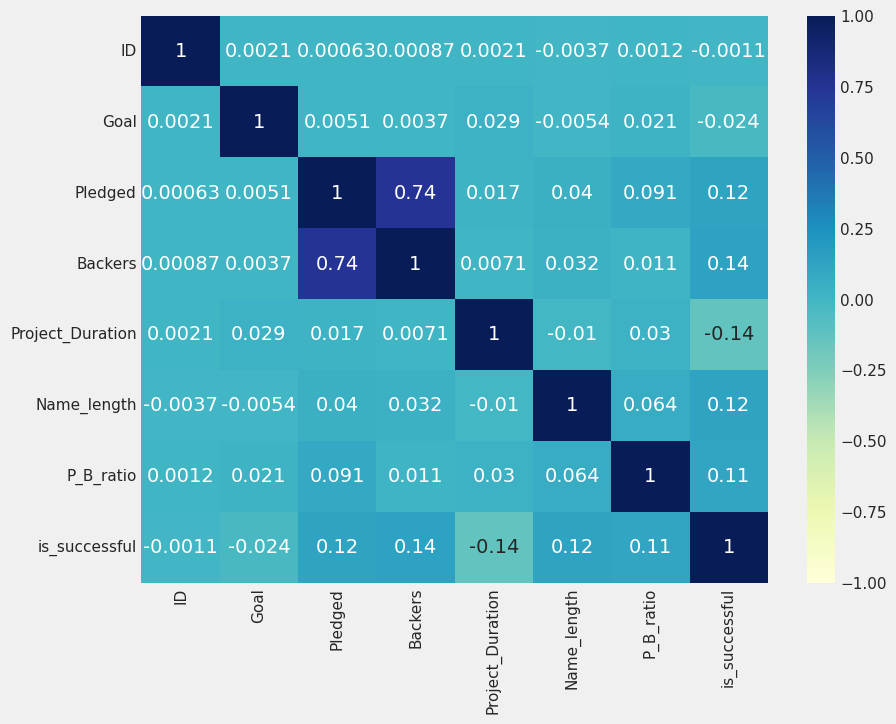

In [178]:
# creating a correlation matrix:
corr_matrix = df2.corr(numeric_only=True)
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix , vmax=1, vmin=-1, annot=True, cmap="YlGnBu")

## Splitting the dataset

In [179]:
# defining x and y:
y = df2['is_successful']
X = df2[['Category', 'Subcategory', 'Country', 'launch_month', 'Launch_Day', 'Goal', 'Project_Duration', 'Name_length']]
#
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RSEED)

In [180]:
# Join features and target for plotting
df_train = pd.concat([X_train, y_train], axis=1)


In [181]:
# how many projects went crazy with their goals?
df2[df2['Goal']>150000000.00]

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State,Launch_date,Project_Duration,Name_length,P_B_ratio,launch_month,Launch_Day,is_successful
151823,1243678698,FUCK Potato Salad. Paleo Potato Brownies!,Food,Food,United Kingdom,2014-07-09 00:24:34,2014-08-08,166361391,0,0,Failed,2014-07-09,29,41,NaN,July,Wednesday,0
259693,2000749004,A Celtic Lovestory,Film & Video,Drama,United Kingdom,2015-11-17 00:47:15,2015-11-30,151395870,0,0,Failed,2015-11-17,12,18,NaN,November,Tuesday,0


# Modelling

* Baseline modell
* defining 3 models - categorical (KNN, Logistic Regression and DeTree)
* GridSearchCV and ensemble methods ( RandomForest und AdaBoost etc.)
* Confusion-Matrix for each model + ensemble

### Baseline-modell:

In [220]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

# Baseline-Modell: here, it predicts in a uniformed way:
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)

# predicting with the baseline-modell
y_pred = dummy.predict(X_test)
print("Baseline-Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Baseline-Accuracy: 0.530686549820858

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62     31912
           1       0.39      0.38      0.38     19723

    accuracy                           0.53     51635
   macro avg       0.50      0.50      0.50     51635
weighted avg       0.53      0.53      0.53     51635



In [191]:
df2.State.unique()

array(['Successful', 'Failed'], dtype=object)

## Preparation of the categorical and numerical features + Pipelining

In [192]:
# separate Nummeric from categoric:
col_num = list(X_train.columns[X_train.dtypes!=object])
col_cat = list(X_train.columns[X_train.dtypes==object])
col_num, col_cat

(['Goal', 'Project_Duration', 'Name_length'],
 ['Category', 'Subcategory', 'Country', 'launch_month', 'Launch_Day'])

In [193]:
# Pipeline for numerical features 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_predict

num_pipeline = Pipeline([('std_scaler', StandardScaler())])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, col_num),
    ('cat', cat_pipeline, col_cat)])



## 1. Modell: Logistic Regression

In [232]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

# cross validation und prediction:
y_train_predicted = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)

# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

Cross validation scores:
-------------------------
Accuracy: 0.69
Recall: 0.45
Precision: 0.62


In [195]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' in front of the corresponding hyperparameters. 

from sklearn.model_selection import GridSearchCV

param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag', 'newton']
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [188]:
#grid_logreg.fit(X_train, y_train)

In [189]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model = grid_logreg.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'Project_Duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country', 'launch_month',
                                                   'Launch_Day'])])),
                ('logreg',
                 LogisticRegression(C=10, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
ŷ_train_LogReg = best_model.predict(X_test)
ŷ_test_LogReg = best_model.predict(X_test)

print("Accuracy Train: {:.2f}".format(accuracy_score(y_test, ŷ_train_LogReg)))
print("Recall Train: {:.2f}".format(recall_score(y_test, ŷ_train_LogReg)))
print("Precision Train: {:.2f}".format(precision_score(y_test, ŷ_train_LogReg)))
print("Accuracy Test: {:.2f}".format(accuracy_score(y_test, ŷ_test_LogReg)))
print("Recall Test: {:.2f}".format(recall_score(y_test, ŷ_test_LogReg)))
print("Precision Test: {:.2f}".format(precision_score(y_test, ŷ_test_LogReg)))

Accuracy: 0.67
Recall: 0.48
Precision: 0.61


In [ ]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy train: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

Cross validation scores:
-------------------------
Accuracy train: 0.67
Recall: 0.47
Precision: 0.62


In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

results_train = confusion_matrix(y_train, y_train_predicted)
results_test = confusion_matrix(y_test, y_test_predicted)

NameError: name 'y_test_predicted' is not defined

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler

<Axes: >

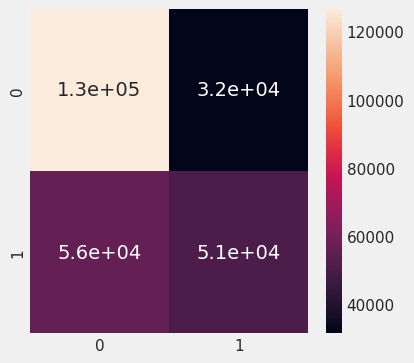

In [ ]:
sns.heatmap(results_train, annot=True)

<Axes: >

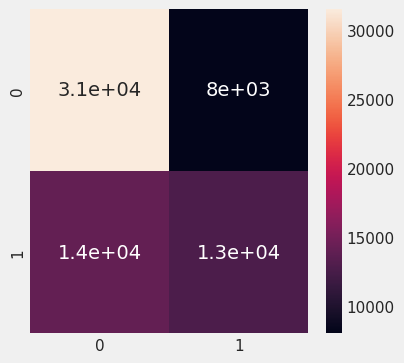

In [ ]:
# Print confusion matrix
sns.heatmap(results_test, annot=True)


## 2. Model: KNN

In [196]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_KNN = Pipeline([
    ('preprocessor', preprocessor),
    ('KNN', KNeighborsClassifier(n_neighbors=5))
])

# cross validation und prediction:
y_train_predicted_knn = cross_val_predict(pipe_KNN, X_train, y_train, cv=5)

# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_knn)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_knn)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_knn)))

Cross validation scores:
-------------------------
Accuracy: 0.64
Recall: 0.46
Precision: 0.53


In [ ]:
# Defining parameter space for grid-search cross validation with KNN:

param_KNN = {   'KNN__n_neighbors': (6,9),
                'KNN__weights': ('uniform', 'distance'),
                'KNN__metric': ['euclidean', 'manhattan']
               }

grid_KNN = GridSearchCV(pipe_KNN, param_grid=param_KNN, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [ ]:
#grid_KNN.fit(X_train, y_train)

## 3. Model: Decision Tree

In [ ]:
# Building a full pipeline with our preprocessor and a Decision Tree Classifier

pipe_DeTree = Pipeline([
    ('preprocessor', preprocessor),
    ('DeTree', DecisionTreeClassifier(random_state=RSEED))
])

# cross validation und prediction:
y_train_predicted_DeTree = cross_val_predict(pipe_DeTree, X_train, y_train, cv=5)

# Calculating the accuracy for the Decision Tree Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_DeTree)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_DeTree)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_DeTree)))

Cross validation scores:
-------------------------
Accuracy: 0.61
Recall: 0.49
Precision: 0.52


In [ ]:
# Defining parameter space for grid-search cross validation with DeTree:

param_DeTree = {  'DeTree__criterion': ('gini', 'entropy', 'log_loss'),
                'DeTree__max_depth': range(8,13),
                'DeTree__splitter':('best','random'),
                'DeTree__min_samples_split': (2,3,4)
               }

grid_DeTree = GridSearchCV(pipe_DeTree, param_grid=param_DeTree, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [ ]:
grid_DeTree.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END DeTree__criterion=gini, DeTree__max_depth=8, DeTree__min_samples_split=2, DeTree__splitter=best;, score=0.662 total time=   1.7s
[CV 2/5] END DeTree__criterion=gini, DeTree__max_depth=8, DeTree__min_samples_split=2, DeTree__splitter=best;, score=0.661 total time=   2.1s
[CV 3/5] END DeTree__criterion=gini, DeTree__max_depth=8, DeTree__min_samples_split=2, DeTree__splitter=best;, score=0.660 total time=   2.2s
[CV 4/5] END DeTree__criterion=gini, DeTree__max_depth=8, DeTree__min_samples_split=2, DeTree__splitter=best;, score=0.662 total time=   2.3s
[CV 1/5] END DeTree__criterion=gini, DeTree__max_depth=8, DeTree__min_samples_split=2, DeTree__splitter=random;, score=0.652 total time=   1.9s
[CV 2/5] END DeTree__criterion=gini, DeTree__max_depth=8, DeTree__min_samples_split=2, DeTree__splitter=random;, score=0.652 total time=   1.9s
[CV 5/5] END DeTree__criterion=gini, DeTree__max_depth=8, DeTree__min_samples_spli

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['Goal',
                                                                          'Project_Duration']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Category',
                                                                          'Subcategory',
                                                                          'Country',
                                                                          'launch_month',
                                                                          'Launch_Day'])])),
                                       ('DeTree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'DeTree__criterion': ('gini', 'entropy', 'log_loss'),
                         'DeTree__max_depth': range(8, 13),
                         'DeTree__min_samples_split': (2, 3, 4),
                         'DeTree__splitter': ('best', 'random')},
             scoring='accuracy', verbose=5)

In [ ]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_DeTree.best_score_))
print("Best parameters:\n{}".format(grid_DeTree.best_params_))

Best score:
0.67
Best parameters:
{'DeTree__criterion': 'entropy', 'DeTree__max_depth': 12, 'DeTree__min_samples_split': 3, 'DeTree__splitter': 'best'}


In [ ]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model_DeTree = grid_DeTree.best_estimator_
best_model_DeTree

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'Project_Duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country', 'launch_month',
                                                   'Launch_Day'])])),
                ('DeTree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=12,
                                        min_samples_split=3,
                                        random_state=42))])

In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_train_predicted_DeTree = best_model_DeTree.predict(X_train)

print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

Accuracy: 0.67
Recall: 0.47
Precision: 0.62


In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted_DeTree = best_model_DeTree.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_DeTree)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_DeTree)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_DeTree)))

Accuracy: 0.66
Recall: 0.44
Precision: 0.62


## Ensemble-Methods

* Random Forest (Bagging)
* Voting Classifier
* Stacking
* Boosting (AdaBoost/XGBoost)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

In [ ]:
pipe_RaFo = Pipeline([
    ('preprocessor', preprocessor),
    ('RaFo', RandomForestClassifier(n_estimators=100, # der wird ca 4 min brauchen
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1))
])

# cross validation und prediction:
y_train_predicted_RaFo = cross_val_predict(pipe_RaFo, X_train, y_train, cv=5)

# Calculating the accuracy for the Random Forest Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_RaFo)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_RaFo)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_RaFo)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11

Cross validation scores:
-------------------------
Accuracy: 0.68
Recall: 0.47
Precision: 0.61


In [ ]:
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(C=10,penalty='l1', solver='liblinear' ,random_state = RSEED)
model2 = KNeighborsClassifier()
model3 = DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state = RSEED)
model4 = RandomForestClassifier(n_estimators=100, random_state=RSEED,max_features = 'sqrt', n_jobs=-1, verbose = 1)

model = VotingClassifier(estimators = [('lr', model1), ('knn', model2), ('dt', model3), ('rf', model4)], voting = 'soft')

pipe_Voting = Pipeline([
    ('preprocessor', preprocessor),
    ('VotingModel', model)])

pipe_Voting.fit(X_train,y_train)


# Braucht rund 1,5 min

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'Project_Duration',
                                                   'Name_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country', 'launch_month',
                                                   'Launch_Day'])])),
                ('VotingModel',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=10,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear')),
                                              ('knn', KNeighborsClassifier()),
                                              ('dt',
                                               DecisionTreeClassifier(criterion='entropy',
                                                                      max_depth=12,
                                                                      random_state=42)),
                                              ('rf',
                                               RandomForestClassifier(n_jobs=-1,
                                                                      random_state=42,
                                                                      verbose=1))],
                                  voting='soft'))])

In [ ]:
pipe_Voting.score(X_train,y_train) # score of the trainings-dataset ....overfit?
# Braucht rund 3,5 min

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.4s finished


0.8654423441918117

In [ ]:
pipe_Voting.score(X_test,y_test) # score of the test-dataset
# Braucht rund 1 min

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


0.6850779510022271

In [237]:
model_hard = VotingClassifier(estimators = [('lr', model1), ('knn', model2), ('dt', model3), ('rf', model4)], voting = 'hard')

pipe_Voting_hard = Pipeline([
    ('preprocessor', preprocessor),
    ('VotingModel', model)])

pipe_Voting_hard.fit(X_train,y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'Project_Duration',
                                                   'Name_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country', 'launch_month',
                                                   'Launch_Day'])])),
                ('VotingModel',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=10,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear')),
                                              ('knn', KNeighborsClassifier()),
                                              ('dt',
                                               DecisionTreeClassifier(criterion='entropy',
                                                                      max_depth=12,
                                                                      random_state=42)),
                                              ('rf',
                                               RandomForestClassifier(n_jobs=-1,
                                                                      random_state=42,
                                                                      verbose=1))],
                                  voting='soft'))])

In [238]:
pipe_Voting_hard.score(X_train,y_train) #score of the trainings-dataset (hard voting)
# rund 3,5 min


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.4s finished


0.8654423441918117

In [239]:
pipe_Voting_hard.score(X_test,y_test) #score of the test-dataset (hard voting)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


0.6850779510022271

In [ ]:
# Implementation of Stacking in Scikit-Learn - this may overfit!
from sklearn.ensemble import StackingClassifier

estimators = [
    ('model1', model1),
    ('model2', model2),
    ('model4', model4) # random forest statt decision tree

]

clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())

pipe_Stacking = Pipeline([
    ('preprocessor', preprocessor),
    ('Stacking', clf)])

pipe_Stacking.fit(X_train, y_train)
 
# ca 8,5 min

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'Project_Duration',
                                                   'Name_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country', 'launch_month',
                                                   'Launch_Day'])])),
                ('Stacking',
                 StackingClassifier(estimators=[('model1',
                                                 LogisticRegression(C=10,
                                                                    penalty='l1',
                                                                    random_state=42,
                                                                    solver='liblinear')),
                                                ('model2',
                                                 KNeighborsClassifier()),
                                                ('model4',
                                                 RandomForestClassifier(n_jobs=-1,
                                                                        random_state=42,
                                                                        verbose=1))],
                                    final_estimator=LogisticRegression()))])

In [241]:
ŷ_train_stack = pipe_Stacking.predict(X_train)
pipe_Stacking.score(X_train, y_train)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.5s finished


0.9198977417980401

In [259]:
ŷ_test_stack = pipe_Stacking.predict(X_test)
pipe_Stacking.score(X_test, y_test)
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_test, ŷ_test_stack)))
print("Recall: {:.2f}".format(recall_score(y_test, ŷ_test_stack)))
print("Precision: {:.2f}".format(precision_score(y_test, ŷ_test_stack)))
print("F1-Score: {:.2f}".format(f1_score(y_test, ŷ_test_stack)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


Cross validation scores:
-------------------------
Accuracy: 0.69
Recall: 0.46
Precision: 0.63
F1-Score: 0.53


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


In [243]:
# f1 scores!

f1_train_Stack = f1_score(y_true=y_train, y_pred=ŷ_train_stack)
f1_test_Stack = f1_score(y_true=y_test, y_pred=ŷ_test_stack)
print(f'The F1 Score of the trainings-datatset is: {f1_train_Stack}')
print(f'The F1 Score of the test-datatset is: {f1_test_Stack}')


The F1 Score of the trainings-datatset is: 0.8884934756820878
The F1 Score of the test-datatset is: 0.5335666375036454


In [ ]:
# applying boosting...somehow:

from xgboost import XGBClassifier

XGBoost = XGBClassifier()

pipe_Boost = Pipeline([
    ('preprocessor', preprocessor),
    ('Boosting', XGBoost)])

pipe_Boost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'Project_Duration',
                                                   'Name_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country', 'launch_month',
                                                   'Launch_Day'])])),
                ('Boosting',
                 XGBClassifier(base_score=None, bo...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [249]:
ŷ_train_Boost = pipe_Boost.predict(X_train)
pipe_Boost.score(X_train, y_train)

0.7210413680907929

In [ ]:
ŷ_test_Boost = pipe_Boost.predict(X_test)
pipe_Boost.score(X_test, y_test)


0.7018688873825893

In [251]:

f1_train_Boost = f1_score(y_true=y_train, y_pred=ŷ_train_Boost)
f1_test_Boost = f1_score(y_true=y_test, y_pred=ŷ_test_Boost)
print(f'The F1 Score of the trainings-datatset is: {f1_train_Boost}')
print(f'The F1 Score of the test-datatset is: {f1_test_Boost}')

The F1 Score of the trainings-datatset is: 0.5894642335454358
The F1 Score of the test-datatset is: 0.5595169966807829


In [252]:
# Defining parameter space for grid-search cross validation with DeTree:

param_XGB = {   'Boosting__max_depth': (5,7,8,12),
                'Boosting__sampling_method':('uniform','gradient_based'),
               }

grid_XGB = GridSearchCV(pipe_Boost, param_grid=param_XGB, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [253]:
grid_XGB.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 5/5] END Boosting__max_depth=5, Boosting__sampling_method=uniform;, score=0.703 total time=  18.2s
[CV 2/5] END Boosting__max_depth=5, Boosting__sampling_method=uniform;, score=0.700 total time=  19.5s
[CV 1/5] END Boosting__max_depth=5, Boosting__sampling_method=uniform;, score=0.705 total time=  20.2s
[CV 3/5] END Boosting__max_depth=5, Boosting__sampling_method=uniform;, score=0.705 total time=  20.1s
[CV 1/5] END Boosting__max_depth=5, Boosting__sampling_method=gradient_based;, score=0.705 total time=  20.6s
[CV 5/5] END Boosting__max_depth=5, Boosting__sampling_method=gradient_based;, score=0.703 total time=  19.7s
[CV 4/5] END Boosting__max_depth=5, Boosting__sampling_method=gradient_based;, score=0.705 total time=  20.0s
[CV 4/5] END Boosting__max_depth=5, Boosting__sampling_method=uniform;, score=0.705 total time=  21.7s
[CV 3/5] END Boosting__max_depth=5, Boosting__sampling_method=gradient_based;, score=0.705 tota

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['Goal',
                                                                          'Project_Duration',
                                                                          'Name_length']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Category',
                                                                          'Subcategory',
                                                                          'Country',
                                                                          'launch_month',
                                                                          'Launch_Day'])])),
                                       ('Boosting',
                                        XGBC...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'Boosting__max_depth': (5, 7, 8, 12),
                         'Boosting__sampling_method': ('uniform',
                                                       'gradient_based')},
             scoring='accuracy', verbose=5)

In [255]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_XGB.best_score_))
print("Best parameters:\n{}".format(grid_XGB.best_params_))


# Save best model (including fitted preprocessing steps) as best_model 
best_model_XGB = grid_XGB.best_estimator_
best_model_XGB

Best score:
0.70
Best parameters:
{'Boosting__max_depth': 5, 'Boosting__sampling_method': 'uniform'}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'Project_Duration',
                                                   'Name_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country', 'launch_month',
                                                   'Launch_Day'])])),
                ('Boosting',
                 XGBClassifier(base_score=None, bo...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [256]:
ŷ_train_BoostCV = best_model_XGB.predict(X_train)
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, ŷ_train_BoostCV)))
print("Recall: {:.2f}".format(recall_score(y_train, ŷ_train_BoostCV)))
print("Precision: {:.2f}".format(precision_score(y_train, ŷ_train_BoostCV)))
print("F1-Score: {:.2f}".format(f1_score(y_train, ŷ_train_BoostCV)))

Cross validation scores:
-------------------------
Accuracy: 0.71
Recall: 0.51
Precision: 0.67
F1-Score: 0.57


In [258]:
ŷ_test_BoostCV = best_model_XGB.predict(X_test)
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_test, ŷ_test_BoostCV)))
print("Recall: {:.2f}".format(recall_score(y_test, ŷ_test_BoostCV)))
print("Precision: {:.2f}".format(precision_score(y_test, ŷ_test_BoostCV)))
print("F1-Score: {:.2f}".format(f1_score(y_test, ŷ_test_BoostCV)))

Cross validation scores:
-------------------------
Accuracy: 0.70
Recall: 0.48
Precision: 0.64
F1-Score: 0.55
